## NDVI Hotspots

This notebook identifies NDVI hot and cold spots from a time series of Level-2 Landsat 8 satellite images.

### Imports

In [1]:
import planetary_computer as pc

import numpy as np
import xarray as xr
import rioxarray

import rasterio
import stackstac
import pystac_client

import matplotlib.pyplot as plt

import xrspatial.multispectral as ms
from xrspatial.convolution import circle_kernel, calc_cellsize
from xrspatial.focal import hotspots

from dask_gateway import GatewayCluster

### Dask Cluster

In [2]:
cluster = GatewayCluster()  # Creates the Dask Scheduler. Might take a minute.

client = cluster.get_client()

cluster.adapt(minimum=4, maximum=24)
print(cluster.dashboard_link)

https://pcc-staging.westeurope.cloudapp.azure.com/compute/services/dask-gateway/clusters/staging.91c5892f84284210a0cc273132bb4e6d/status


### Data

In this example, we use image data from the `landsat-8-c2-l2` collection within a bounding box of `[-116.54571533203126, 39.251397769004924, -115.44708251953126, 40.096983167279575]` in 5 years from 2016 to 2020. Only images with less than 25% cloud coverage are selected.

In [3]:
bbox = [
    -116.54571533203126,
    39.251397769004924,
    -115.44708251953126,
    40.096983167279575
]

dt = "2016-01-01/2020-12-31"

In [4]:
catalog = pystac_client.Client.open('https://planetarycomputer.microsoft.com/api/stac/v1')
search = catalog.search(
    collections=['landsat-8-c2-l2'],
    bbox=bbox,
    datetime=dt,    
)    
search.matched()

457

In [5]:
items = search.items()
items = [x for x in items if x.properties['eo:cloud_cover'] < 25]
items = [pc.sign_assets(i).to_dict() for i in items]
len(items)

286

Consider 4 bands: blue, green, red and nir08

In [6]:
data = (
    stackstac.stack(
        items,
        epsg=32619,
        resolution=500,
        assets=['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5']  # blue, green, red, nir
    )
    .where(lambda x: x > 0, other=np.nan)  # sometimes Landsat-8 uses 0 as nodata
    .assign_coords(band = lambda x: x.common_name.rename("band"))  # use common names
)
data

,Array,Chunk
Bytes,10.99 GiB,8.00 MiB
Shape,"(286, 4, 1239, 1041)","(1, 1, 1024, 1024)"
Count,16020 Tasks,4576 Chunks
Type,float64,numpy.ndarray


In [7]:
data = data.persist()

Let's get the data for each year separately so that we can see the changes over time.

In [8]:
annually = data.groupby("time.year").median()
annually

<xarray.DataArray 'stackstac-3ebb24c258235e3bf4743f8bf318b6de' (year: 5, band: 4, y: 1239, x: 1041)>
dask.array<stack, shape=(5, 4, 1239, 1041), dtype=float64, chunksize=(1, 1, 512, 256), chunktype=numpy.ndarray>
Coordinates: (12/19)
  * band                         (band) <U5 'blue' 'green' 'red' 'nir08'
  * x                            (x) float64 -3.922e+06 ... -3.402e+06
  * y                            (y) float64 5.914e+06 5.914e+06 ... 5.296e+06
    landsat:collection_number    <U2 '02'
    landsat:collection_category  <U2 'T1'
    landsat:processing_level     <U4 'L2SP'
    ...                           ...
    title                        (band) <U27 'Blue Band (B2)' ... 'Near Infra...
    common_name                  (band) <U5 'blue' 'green' 'red' 'nir08'
    center_wavelength            (band) float64 0.48 0.56 0.65 0.86
    full_width_half_max          (band) object None 0.06 0.04 0.03
    epsg                         int64 32619
  * year                         (year) int64 2016 2017 2018 2019 2020

In [9]:
annually = annually.compute()

### NDVI

NDVI for annual data can be calculated with `xarray-spatial` as below.

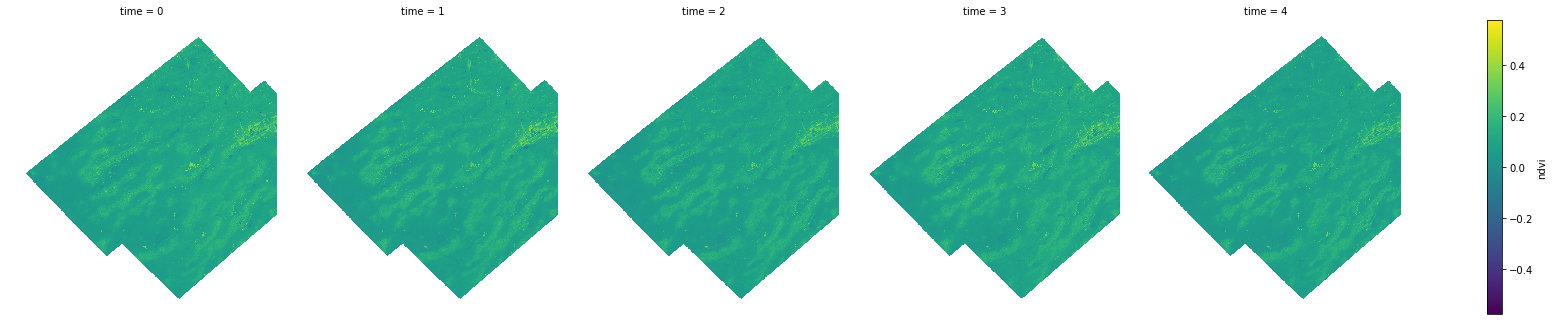

In [11]:
ndvi_aggs = [
    ms.ndvi(x.sel(band='nir08'), x.sel(band='red')) for x in annually
]

ndvi_images = xr.concat(ndvi_aggs, dim="time")

g = ndvi_images.plot.imshow(x="x", y="y", cmap='viridis',col="time", col_wrap=5, figsize=(25, 5))
for ax in g.axes.flat:
    ax.set_axis_off()


### Hotspots

To identify hot and cold spots in a data aggregate, we need to provide a kernel, which is a numpy ndarray, along with the input data array to be analysed. 

In this example, we consider a circular kernel with a radius of 10 times the cellsize of the input data array. 

In [12]:
cellsize = calc_cellsize(annually)
cellsize

/srv/conda/envs/notebook/lib/python3.8/site-packages/xrspatial/convolution.py:168: Warning: Raster distance unit not provided. Use meter as default.
  warnings.warn('Raster distance unit not provided. '


(500.0, 500.0)

In [13]:
kernel = circle_kernel(*cellsize, radius=10*cellsize[0])

/srv/conda/envs/notebook/lib/python3.8/site-packages/xrspatial/convolution.py:58: Warning: Raster distance unit not provided. Use meter as default.
  warnings.warn('Raster distance unit not provided. '


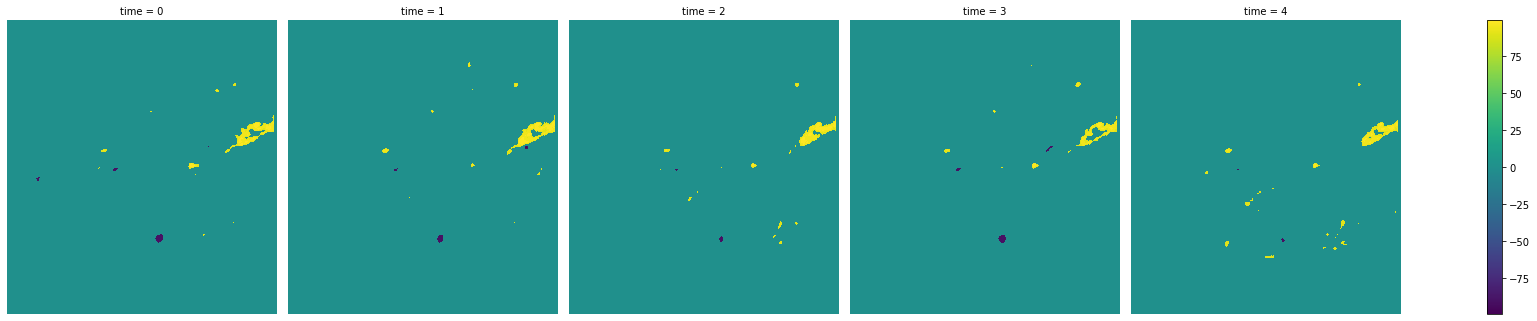

In [14]:
hotspots_aggs = [
    hotspots(ndvi_agg, kernel) for ndvi_agg in ndvi_aggs
]
hotspots_images = xr.concat(hotspots_aggs, dim="time")

g = hotspots_images.plot.imshow(x="x", y="y", cmap='viridis', col="time", col_wrap=5, figsize=(25, 5))
for ax in g.axes.flat:
    ax.set_axis_off()